In [ ]:
import numpy as np
import pickle

path='/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'

In [2]:
import numpy as np
import pickle
from scipy.special import softmax
import matplotlib.pyplot as plt

# Path to your ViT embeddings
path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
#path='/home/maria/Documents/HuggingMouseData/CIFARLogits/cifar100_resnet56_embeddings_logits.pkl'
#path='/home/maria/Documents/HuggingMouseData/CIFARLogits/cifar10_resnet56_embeddings_logits.pkl'
# Load
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

# Convert to a matrix
# If vit_dict is {image_id: logits_vector}
embeddings = np.stack(list(vit_dict))  # shape: (N_images, n_classes)
print("Embeddings shape:", embeddings.shape)

# Compute softmax over classes
softmax_embeddings = softmax(embeddings, axis=1)


Embeddings shape: (118, 1000)


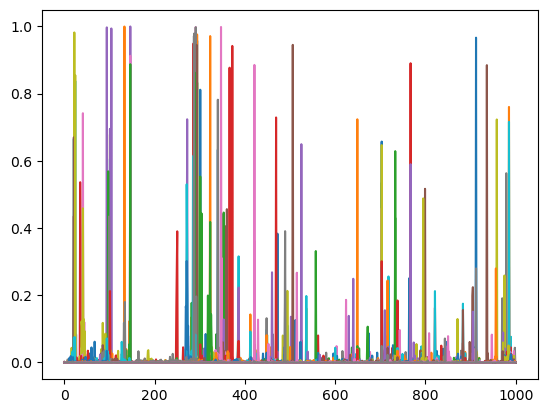

In [21]:
plt.plot(softmax_embeddings.T)

Entropy stats:
  mean = 2.582
  std  = 2.023
  min  = 0.006
  max  = 6.243


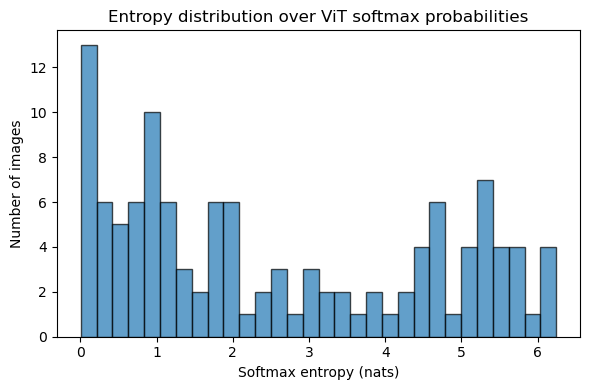

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute entropy per image ---
# small epsilon to avoid log(0)
eps = 1e-12
entropies = -np.sum(softmax_embeddings * np.log(softmax_embeddings + eps), axis=1)

print(f"Entropy stats:\n  mean = {entropies.mean():.3f}\n  std  = {entropies.std():.3f}\n"
      f"  min  = {entropies.min():.3f}\n  max  = {entropies.max():.3f}")

# --- Plot histogram ---
plt.figure(figsize=(6, 4))
plt.hist(entropies, bins=30, color='tab:blue', alpha=0.7, edgecolor='k')
plt.xlabel("Softmax entropy (nats)")
plt.ylabel("Number of images")
plt.title("Entropy distribution over ViT softmax probabilities")
plt.tight_layout()
plt.show()


Pearson r = 0.125 (p=1.77e-01)
Spearman ρ = 0.137 (p=1.38e-01)


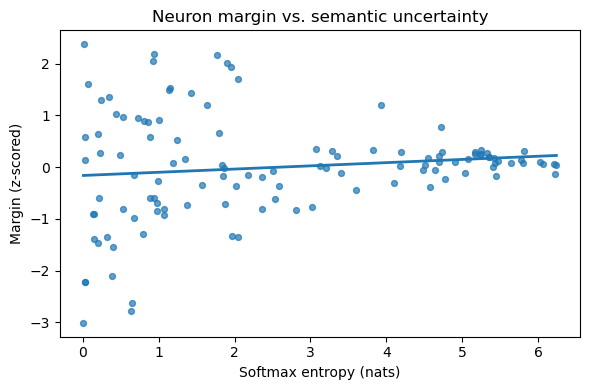

/tmp/ipykernel_8786/243856658.py:50: RuntimeWarning: Mean of empty slice.
  bin_means = [margins_z[digit==b].mean() for b in range(len(bins))]


ValueError: x and y must have same first dimension, but have shapes (7,) and (8,)

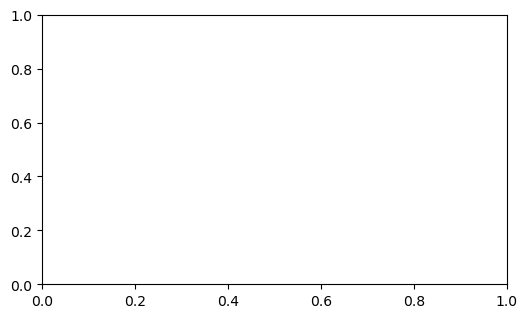

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

P = softmax_embeddings                      # shape: (N_images, n_classes)
eps = 1e-12
entropy = -np.sum(P * np.log(P + eps), axis=1)    # per-image entropy (nats)

# ---- choose a "neuron" direction w ----
# Option A: random semantic direction
rng = np.random.default_rng(0)
w = rng.standard_normal(P.shape[1])
w /= np.linalg.norm(w)                      # unit vector

# (Option B: PCA first component – emphasizes common variance)
# from sklearn.decomposition import PCA
# w = PCA(n_components=1).fit(P).components_[0]
# w /= np.linalg.norm(w)

# (Option C: pick a class prototype, e.g., "dog-ish" – replace idx)
# idx = 207  # example ImageNet class index
# w = np.zeros(P.shape[1]); w[idx] = 1.0

# ---- margin projection (decision variable) ----
margins = P @ w                             # shape: (N_images,)
# (Optional) z-score margins to compare across w's
margins_z = (margins - margins.mean()) / (margins.std() + 1e-8)

# ---- correlation: does the neuron like confident or ambiguous scenes? ----
pear = pearsonr(margins, entropy)
spear = spearmanr(margins, entropy)
print(f"Pearson r = {pear.statistic:.3f} (p={pear.pvalue:.2e})")
print(f"Spearman ρ = {spear.correlation:.3f} (p={spear.pvalue:.2e})")

# ---- visualization ----
plt.figure(figsize=(6,4))
plt.scatter(entropy, margins_z, s=18, alpha=0.7)
z = np.polyfit(entropy, margins_z, 1)
xg = np.linspace(entropy.min(), entropy.max(), 200)
plt.plot(xg, z[0]*xg + z[1], lw=2)
plt.xlabel("Softmax entropy (nats)")
plt.ylabel("Margin (z-scored)")
plt.title("Neuron margin vs. semantic uncertainty")
plt.tight_layout()
plt.show()

# ---- a quick binned trend (robust view) ----
bins = np.quantile(entropy, np.linspace(0,1,8))
digit = np.digitize(entropy, bins[1:-1])
bin_means = [margins_z[digit==b].mean() for b in range(len(bins))]
bin_centers = 0.5*(bins[:-1]+bins[1:])
plt.figure(figsize=(6,3.5))
plt.plot(bin_centers, bin_means, marker='o')
plt.xlabel("Entropy (bin centers)")
plt.ylabel("Mean margin (z)")
plt.title("Binned trend: margin vs. entropy")
plt.tight_layout()
plt.show()


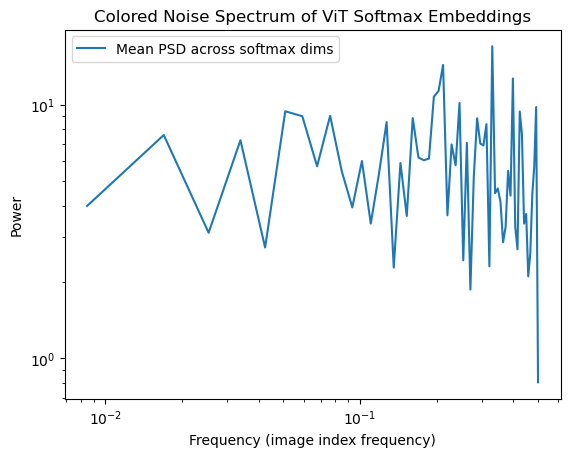

In [12]:
# Compute PSD for each class probability across the image index
N, C = softmax_embeddings.shape
freqs = np.fft.rfftfreq(N)
psd = np.abs(np.fft.rfft(softmax_embeddings - softmax_embeddings.mean(axis=0), axis=0))**2

# Average PSD over all classes
mean_psd = psd.mean(axis=1)

plt.loglog(freqs[1:], mean_psd[1:], label='Mean PSD across softmax dims')
plt.xlabel('Frequency (image index frequency)')
plt.ylabel('Power')
plt.title('Colored Noise Spectrum of ViT Softmax Embeddings')
plt.legend()
plt.show()


In [14]:
print(mean_psd.shape)

(60,)


In [13]:
# Fit spectral exponent
log_f = np.log(freqs[1:])
log_p = np.log(mean_psd[1:])
alpha, intercept = np.polyfit(log_f, log_p, 1)

print(f"Spectral exponent α ≈ {-alpha:.2f}")

Spectral exponent α ≈ 0.07


In [3]:
import numpy as np

minus_one=1/np.sqrt(2*np.pi)*np.e**(-(0.5+1)**2/2)
minus_one
plus_one=1/np.sqrt(2*np.pi)*np.e**(-(0.5-1)**2/2)
plus_one

0.3520653267642995

In [4]:
minus_one

0.12951759566589174

In [6]:
(plus_one*0.5)/(plus_one*0.5+minus_one*0.5)

0.7310585786300048

In [7]:
(0.95*0.01)/(0.95*0.01+0.1*0.99)

0.08755760368663594

In [8]:
(0.95*0.08755760368663594)/(0.95*0.08755760368663594+0.1*(1-0.08755760368663594))

0.4768824306472919

In [9]:
(0.95*0.4768824306472919)/(0.95*0.4768824306472919+0.1*(1-0.4768824306472919))

0.896484119722912

In [10]:
(0.95*0.896484119722912)/(0.95*0.896484119722912+0.1*(1-0.896484119722912))

0.9879913574163223